In [1]:
#import robot_motion as rm
#import robot_camera
import cv2
from IPython.display import Image
from matplotlib import pyplot as plt
from cv2 import aruco
import os
import numpy as np

In [4]:
#motionsystem = rm.colonyPicker({},{},'/dev/serial0',19200)
#robocam = robot_camera.robo_camera()

In [18]:
#move the needle around and take a picture
motionsystem.move_robot(px=motionsystem.robopos["neutral_position"]["0"]["X"],\
                        py = motionsystem.robopos["neutral_position"]["0"]["Y"],\
                        pz=motionsystem.robopos["neutral_position"]["0"]["Z"])
motionsystem.send_gcode_multiline(["M400"])
motionsystem.light_on()
img = robocam.capture(os.path.join(".","calibration","lighttable.png")) #blank light table photo
zup = 2
motionsystem.move_needle("backlit_plate","needle_pos",retract = False, offset_x = 10,offset_y = -10,offset_z = zup)
motionsystem.send_gcode_multiline(["M400"])
img = robocam.capture(os.path.join(".","calibration","needlepos1.png"))
motionsystem.move_needle("backlit_plate","needle_pos",retract = False, offset_x = 10,offset_y = 10,offset_z=zup)
motionsystem.send_gcode_multiline(["M400"])
img = robocam.capture(os.path.join(".","calibration","needlepos2.png"))
motionsystem.move_needle("backlit_plate","needle_pos",retract = False, offset_x = -10, offset_y = 10,offset_z=zup)
motionsystem.send_gcode_multiline(["M400"])
img = robocam.capture(os.path.join(".","calibration","needlepos3.png"))
motionsystem.move_needle("backlit_plate","needle_pos",retract = False, offset_x = -10, offset_y = -10,offset_z=zup)
motionsystem.send_gcode_multiline(["M400"])
img = robocam.capture(os.path.join(".","calibration","needlepos4.png"))
motionsystem.light_off()

/usr/lib/python3/dist-packages/picamera/encoders.py:544: PiCameraResolutionRounded: frame size rounded up from 1920x1080 to 1920x1088
  width, height, fwidth, fheight)))


In [4]:
#mask the table
ltable = os.path.join(".","calibration","lighttable.png")
bgimg = cv2.imread(ltable)
bgimg_gray = cv2.cvtColor(bgimg,cv2.COLOR_BGR2GRAY)

fgbg = cv2.createBackgroundSubtractorMOG2()
fgmask = fgbg.apply(bgimg_gray) #the first image is the background

kernel = np.ones((5,5), np.uint8) 
ret,thresh = cv2.threshold(bgimg,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) #for some reason this doesn't work even though it did on the pi
thresh = cv2.erode(thresh,kernel,iterations=1) #get rid of noise
thresh = cv2.dilate(thresh,kernel,iterations=2) #fill up the holes
thresh = cv2.erode(thresh,kernel,iterations=4) #make it smaller
#now the mask which represents the table is called "thresh"

#pictures of the colony pick needle going around in a square
npos1 = os.path.join(".","calibration","needlepos1.png")
npos2 = os.path.join(".","calibration","needlepos2.png")
npos3 = os.path.join(".","calibration","needlepos3.png")
npos4 = os.path.join(".","calibration","needlepos4.png")
needle_positions = [npos1,npos2,npos3,npos4]

needlepoints = []

for needpos in needle_positions:
    img = cv2.imread(needpos)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = fgbg.apply(gray,learningRate=0) #learningrate 0 means another image never becomes the new background
    gray = cv2.erode(gray,kernel,iterations=1) #erode a bit to get rid of junk

    ret,threshblurgray = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #next line finds one corner which is the best, in an image which SHOULD contain only one corner!!
    #TODO checks to make sure this worked
    corners = cv2.goodFeaturesToTrack(threshblurgray, 1, .1, 10,mask=thresh,useHarrisDetector=True)
    corners = np.int0(corners)
    needlepoints += [corners[0][0]]
    
'''
#visualize the needle spots
for corner in needlepoints:
    x,y = corner.ravel()
    cv2.circle(img,(x,y),3,50,-1)    
#newimg = cv2.Canny(img,170,80)

cv2.imwrite('testimage.png',img)
Image(filename='testimage.png') 
#'''

img = cv2.imread(os.path.join('.','pictures','A2.png'))
trapezoid = np.array(needlepoints,np.float32)
#below are the points I got when I did the point matching with real pictures
#needlepoints = [[ 926.,  651.],
#                [1117.,  648.],
#                [1106.,  507.],
#                [ 930.,  509.]]


#this next part warps the image so that it is rectified and in the middle of the frame
square = np.array([[0,200],[150,200],[150,50],[0,50]],np.float32)+150
transform = cv2.getPerspectiveTransform(trapezoid,square)
warp = cv2.warpPerspective(img,transform,(500,550))

cv2.imwrite("circularized.png",warp)
Image("circularized.png")



#cv2.imwrite('testimage.png',thresh)
#Image(filename='testimage.png') 

error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-q0nmoxxv\opencv\modules\imgproc\src\featureselect.cpp:365: error: (-215:Assertion failed) _mask.empty() || (_mask.type() == CV_8UC1 && _mask.sameSize(_image)) in function 'cv::goodFeaturesToTrack'


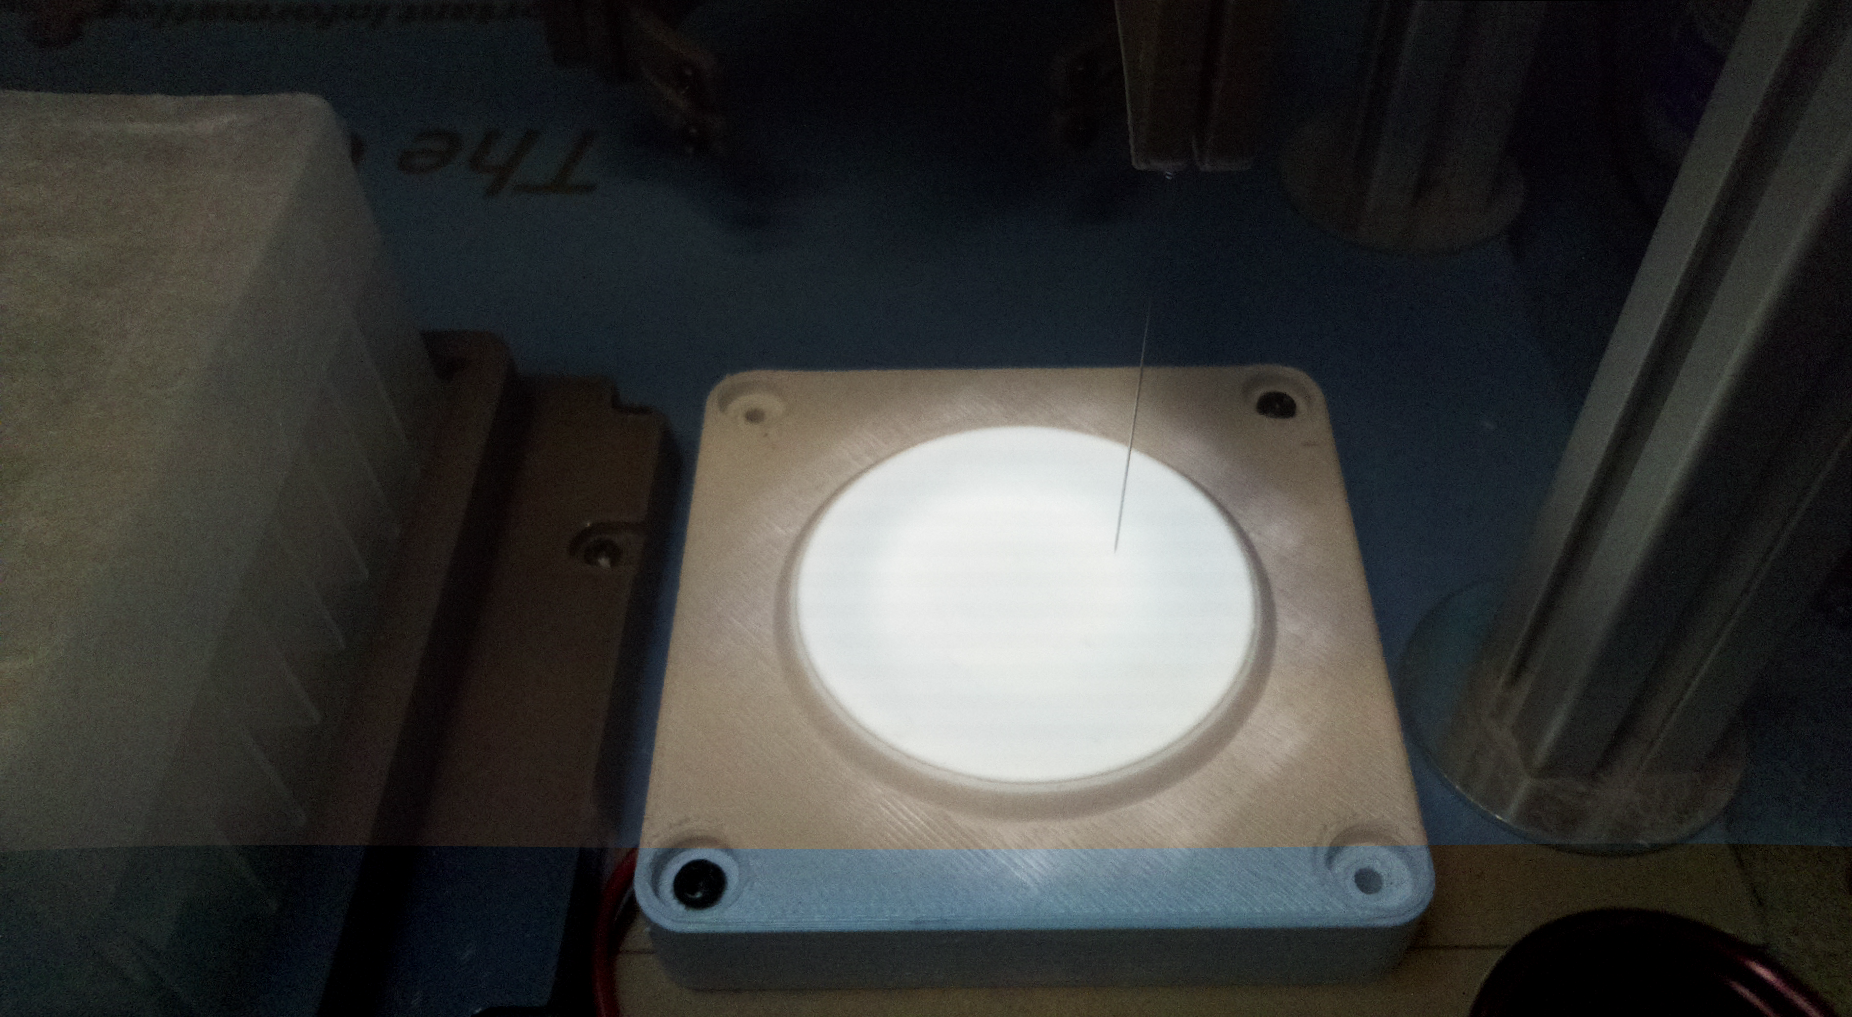

In [20]:

Image(filename='needlepos2.png') 

In [24]:
img = robocam.capture(os.path.join(".","calibration","aruco3.png"))

/usr/lib/python3/dist-packages/picamera/encoders.py:544: PiCameraResolutionRounded: frame size rounded up from 1920x1080 to 1920x1088
  width, height, fwidth, fheight)))


In [25]:
motionsystem.light_off()

[array([[[1205.,  711.],
        [ 894.,  713.],
        [ 900.,  488.],
        [1173.,  486.]]], dtype=float32)]


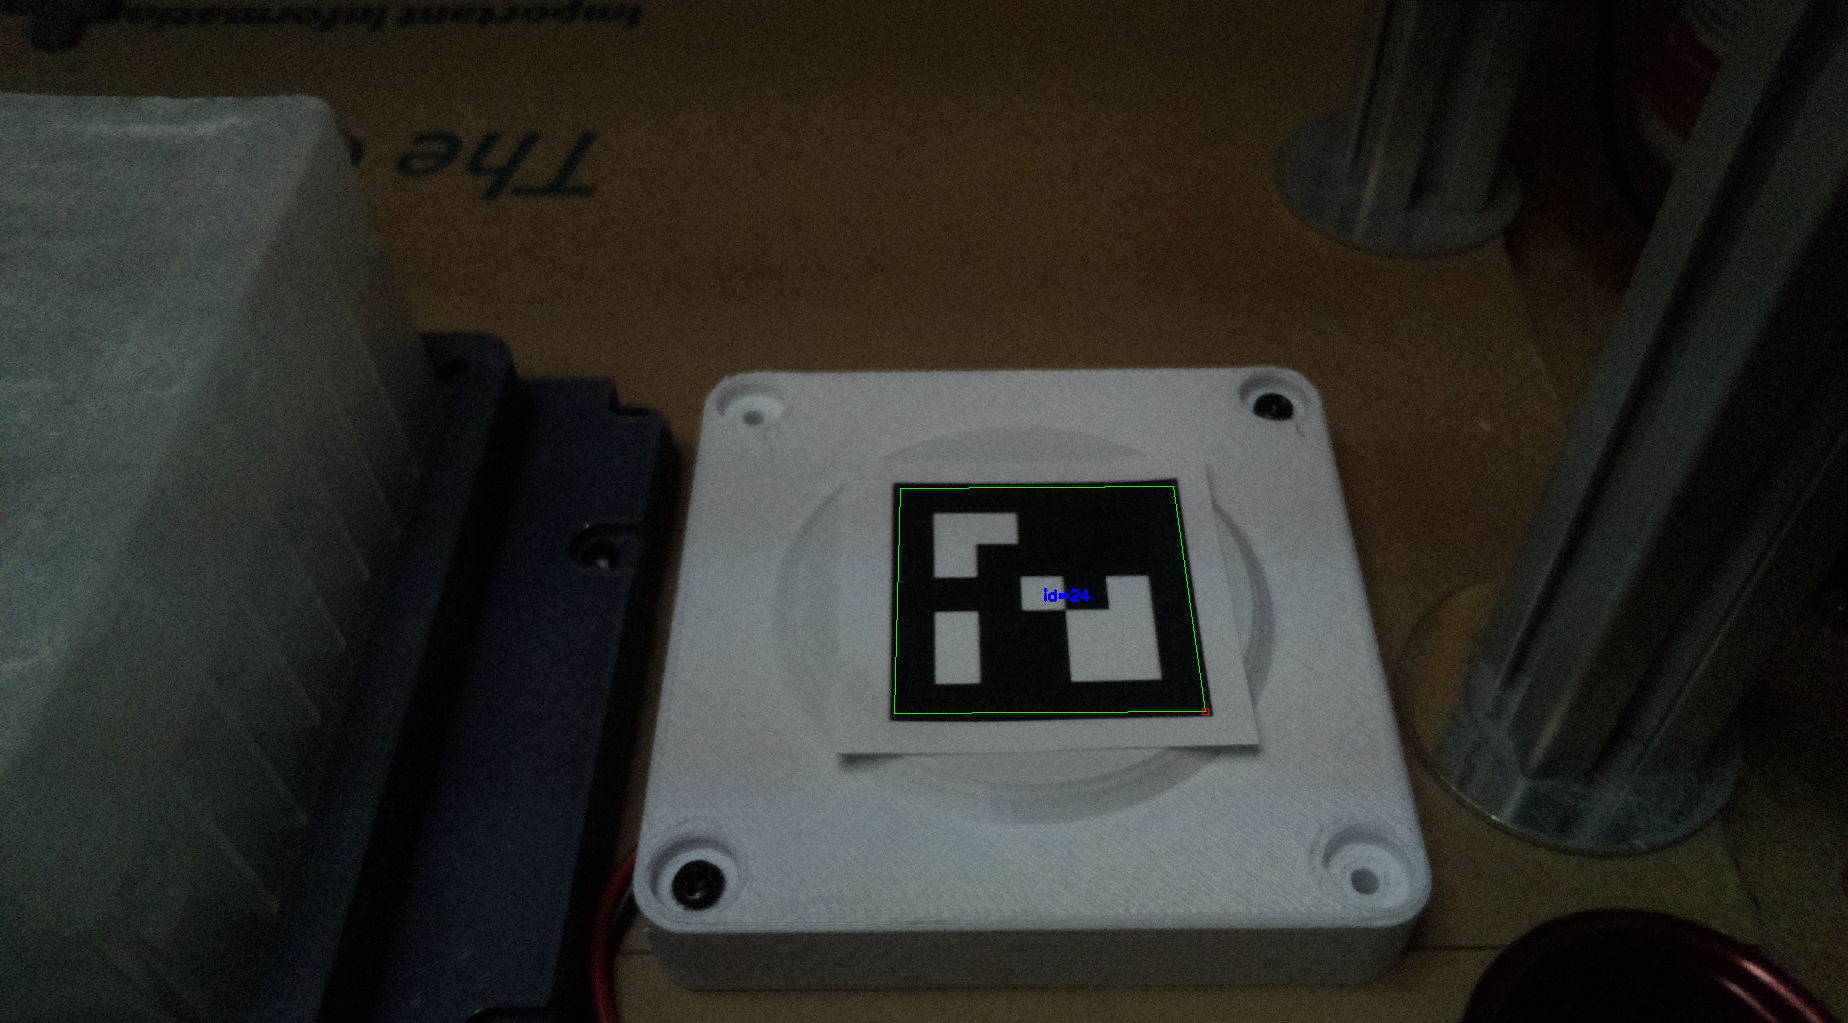

In [8]:
dictionary = aruco.Dictionary_get(aruco.DICT_5X5_250)
parameters =  aruco.DetectorParameters_create()

img = cv2.imread(os.path.join(".","calibration","aruco1.png"))
corners, ids, rejectedCandidates = aruco.detectMarkers(img, dictionary, parameters=parameters)
frame_markers = aruco.drawDetectedMarkers(img.copy(), corners, ids)
#this part is writing and reading an image to display it in the notebook
cv2.imwrite('testimage.png',frame_markers)
print(corners)
Image(filename='testimage.png') 


[1043.   599.5]


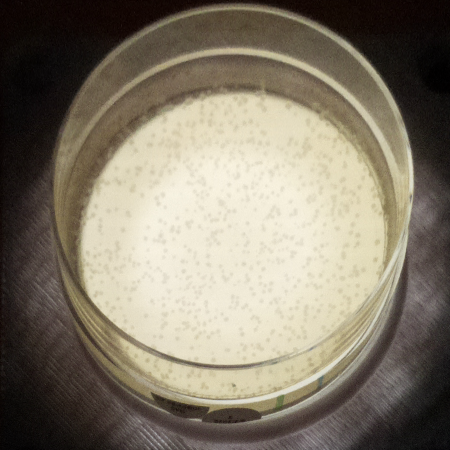

In [144]:
img = cv2.imread(os.path.join('.','pictures','A2.png'))
aruco=np.array([[1205.,  711.],
        [ 894.,  713.],
        [ 900.,  488.],
        [1173.,  486.]], np.float32)

square = np.array([[200,200], [0,200],[0,0],[200,0]],np.float32)+130
transform = cv2.getPerspectiveTransform(aruco,square)
warp = cv2.warpPerspective(img,transform,(450,450))

cv2.imwrite("circularized.png",warp)
Image("circularized.png")

[[[234.5 185.5 182.2]
  [232.5 219.5 172.3]
  [221.5 244.5 175.6]]]


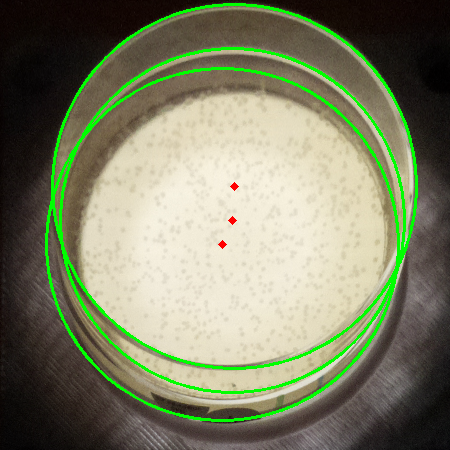

In [145]:
import numpy as np
A1file ='circularized.png' 
img = cv2.imread(A1file)
#newimg = cv2.Canny(img,200,100)
#kernel = np.ones((2,2),np.uint8)
#newimg = cv2.dilate(newimg,kernel,iterations = 1)

cv2.imwrite('testimage.png',newimg)
#cimg = newimg
cimg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#circles = cv2.HoughCircles(cimg,cv2.HOUGH_GRADIENT,1,15,
#                            param1=150,param2=80,minRadius=170,maxRadius=220)
circles = cv2.HoughCircles(cimg,cv2.HOUGH_GRADIENT,1,20,
                            param1=215,param2=57,minRadius=160,maxRadius=185)
print(circles)
circles = np.uint16(np.around(circles))

for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)
cv2.imwrite('testimage.png',img)

Image(filename='testimage.png') 